In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import helper as h
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, ElasticNet

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
plt.style.use('seaborn-darkgrid')

In [2]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=RuntimeWarning, module='statsmodels')
warnings.filterwarnings(action='ignore', category=statsmodels.tools.sm_exceptions.HessianInversionWarning, module='statsmodels')

# Ingradient data cleasing

In [4]:
df_ingredient_prices = pd.read_csv('ingredient_prices.csv')
df_ingredient_prices = df_ingredient_prices.set_index(pd.to_datetime(df_ingredient_prices['Date']))
df_ingredient_prices = df_ingredient_prices.drop(['Date'], axis=1)
df_ingredient_prices['Price'] = df_ingredient_prices['Price'].apply(lambda x: x.replace(',','.') if isinstance(x, str) else x)
df_ingredient_prices['Price'] = df_ingredient_prices['Price'].astype(float)

In [5]:
df_ingredient_prices.shape

(184, 1)

In [6]:
df_ingredient_prices['Price'].isna().sum()

1

###### Remove outliers (simple clipping)

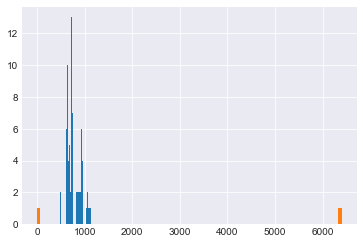

In [7]:
plt.hist(df_ingredient_prices.loc[(df_ingredient_prices['Price']>200) & (df_ingredient_prices['Price']<2000)], bins=100);
plt.hist(df_ingredient_prices.loc[~ ((df_ingredient_prices['Price']>200) & (df_ingredient_prices['Price']<2000))], bins=100);

In [8]:
df_ingredient_prices.loc[~ ((df_ingredient_prices['Price']>200) & (df_ingredient_prices['Price']<2000))] = np.nan

In [9]:
df_ingredient_prices.isna().sum()

Price    3
dtype: int64

In [10]:
df_ingredient_prices = df_ingredient_prices.interpolate(method='time')

<AxesSubplot:xlabel='Date'>

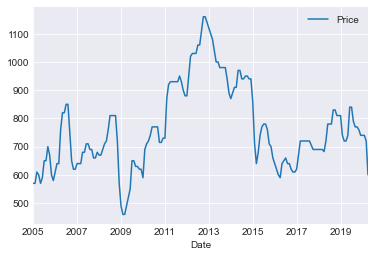

In [11]:
df_ingredient_prices.plot()

# Oil prices data cleasing

In [12]:
df_oil_prices = pd.read_csv('oil_prices.csv')
df_oil_prices = df_oil_prices.set_index(pd.to_datetime(df_oil_prices['Date']))
df_oil_prices = df_oil_prices.drop(['Date'], axis=1)
df_oil_prices['Price'] = df_oil_prices['Price'].apply(lambda x: x.replace(',','.') if isinstance(x, str) else x)
df_oil_prices['Price'] = df_oil_prices['Price'].astype(float)

In [13]:
df_oil_prices.loc[df_oil_prices['Price']>200] = np.nan

In [14]:
df_oil_prices = df_oil_prices.interpolate(method='time')

In [15]:
start_date = df_ingredient_prices.iloc[0].name
start_date

Timestamp('2005-01-01 00:00:00')

<AxesSubplot:xlabel='Date'>

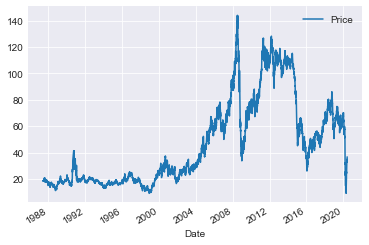

In [16]:
df_oil_prices.plot()

# Feature enginerring/extraction

In [17]:
from scipy.stats import linregress

### Creating features based on oil prices

#### number of consecutive days without oil price information

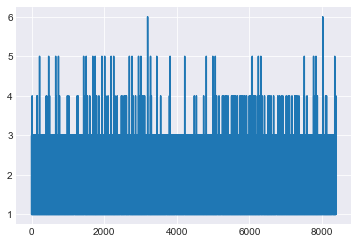

In [18]:
plt.plot((df_oil_prices.index[1:] - df_oil_prices.index[:-1]).days[:])

Prices on weekend are not reported, but statistics are calculated from whole month.

In [19]:
df_oil_features = pd.DataFrame(index=df_oil_prices.resample('M').max().index)

df_oil_features['fst'] = df_oil_prices.resample('M').apply(lambda ser: ser.iloc[0])
df_oil_features['lst'] = df_oil_prices.resample('M').apply(lambda ser: ser.iloc[-1])
df_oil_features['monthly_diff'] = df_oil_features['lst'] - df_oil_features['fst']

maxx = df_oil_prices.resample('M').max()
minn = df_oil_prices.resample('M').min()
df_oil_features['min_max_diff'] =  maxx - minn

df_oil_features['mean'] = df_oil_prices.resample('M').mean()

df_oil_features['pct_change'] = df_oil_features['mean'].pct_change()

df_oil_features['diff'] = df_oil_features['mean'].diff()

df_oil_features['median'] = df_oil_prices.resample('M').median()
df_oil_features['quantile 5%'] = df_oil_prices.resample('M').quantile(0.05)
df_oil_features['quantile 95%'] = df_oil_prices.resample('M').quantile(0.95)
df_oil_features['std'] = df_oil_prices.resample('M').std()
df_oil_features['skewness'] = df_oil_prices.groupby(pd.Grouper(freq='M')).skew()
df_oil_features['kurtosis'] = df_oil_prices.groupby(pd.Grouper(freq='M')).apply(pd.DataFrame.kurt)

## df_oil_features['slope'] = df_oil_prices.groupby(pd.Grouper(freq='M')).apply(lambda v: linregress(np.arange(v.shape[0]), v.Price )[0])

In [20]:
start_date = pd.to_datetime('2004-12-31')
df_oil_features = df_oil_features.resample('M').mean().loc[start_date:].iloc[:-3]
df_oil_features.index = df_oil_features.index + pd.DateOffset(1)
df_oil_features['ingradient_price'] = df_ingredient_prices['Price'].loc[start_date:].copy()
assert(all(df_oil_features.index == df_oil_features['ingradient_price'].index))

In [21]:
# Calculating moving slope and moving mean
# found as useful parameters in econometric
def calc_slope(x):
    slope = np.polyfit(range(len(x)), x, 1)[0]
    return slope

df_oil_features['oil_rolling_mean_3'] = df_oil_features['mean'].rolling(3).mean()#.plot()
df_oil_features['oil_rolling_mean_5'] = df_oil_features['mean'].rolling(5).mean()#.plot()

df_oil_features['oil_rolling_slope_3'] = df_oil_features['mean'].rolling(3).apply(calc_slope)#.plot()
df_oil_features['oil_rolling_slope_5'] = df_oil_features['mean'].rolling(5).apply(calc_slope)#.plot()

### Creating features based on ingradient prices

In [22]:
df_oil_features['ingredient_rolling_mean_3'] = df_oil_features['mean'].rolling(3).mean()#.plot()
df_oil_features['ingredient_rolling_mean_5'] = df_oil_features['mean'].rolling(5).mean()#.plot()

df_oil_features['ingredient_rolling_slope_3'] = df_oil_features['mean'].rolling(3).apply(calc_slope)#.plot()
df_oil_features['ingredient_rolling_slope_5'] = df_oil_features['mean'].rolling(5).apply(calc_slope)#.plot()

In [23]:
df_oil_features.dropna(inplace=True)

In [24]:
df_oil_features

,fst,lst,monthly_diff,min_max_diff,mean,pct_change,diff,median,quantile 5%,quantile 95%,...,kurtosis,ingradient_price,oil_rolling_mean_3,oil_rolling_mean_5,oil_rolling_slope_3,oil_rolling_slope_5,ingredient_rolling_mean_3,ingredient_rolling_mean_5,ingredient_rolling_slope_3,ingredient_rolling_slope_5
Date,,,,,,,,,,,,,,,,,,,,,
2005-05-01,54.14,50.61,-3.53,7.34,51.883810,-0.022987,-1.220736,51.530,49.5200,54.5300,...,-0.185285,570.0,50.154452,46.914906,3.204405,3.315882,50.154452,46.914906,3.204405,3.315882
2005-06-01,50.89,49.30,-1.59,4.47,48.645455,-0.062416,-3.238355,49.270,46.8530,50.5975,...,-1.521513,590.0,51.211270,48.723562,-2.229545,1.468172,51.211270,48.723562,-2.229545,1.468172
2005-07-01,50.46,55.36,4.90,8.04,54.354545,0.117361,5.709091,54.210,51.3030,57.7305,...,-1.579012,650.0,51.627937,50.692671,1.235368,1.330000,51.627937,50.692671,1.235368,1.330000
2005-08-01,56.41,59.77,3.36,4.18,57.520000,0.058237,3.165455,57.510,56.1000,59.0000,...,-0.801529,650.0,53.506667,53.101671,4.437273,1.130165,53.506667,53.101671,4.437273,1.130165
2005-09-01,60.56,66.80,6.24,7.22,63.983478,0.112369,6.463478,64.770,60.1730,66.7880,...,-1.218982,700.0,58.619341,55.277458,4.814466,3.307388,58.619341,55.277458,4.814466,3.307388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-01,60.17,64.50,4.33,4.86,63.211905,0.058595,3.498861,62.720,62.0000,64.9900,...,-0.398998,740.0,61.917205,61.742513,0.192619,-0.074323,61.917205,61.742513,0.192619,-0.074323
2020-01-01,63.20,67.77,4.57,6.75,67.217143,0.063362,4.005238,67.490,63.2000,69.2600,...,0.085084,740.0,63.380697,62.402115,3.752050,1.673589,63.380697,62.402115,3.752050,1.673589
2020-02-01,67.05,57.77,-9.28,12.53,63.645455,-0.053137,-3.571688,64.095,57.8085,69.0630,...,-1.037532,740.0,64.691501,63.322842,0.216775,0.914168,64.691501,63.322842,0.216775,0.914168


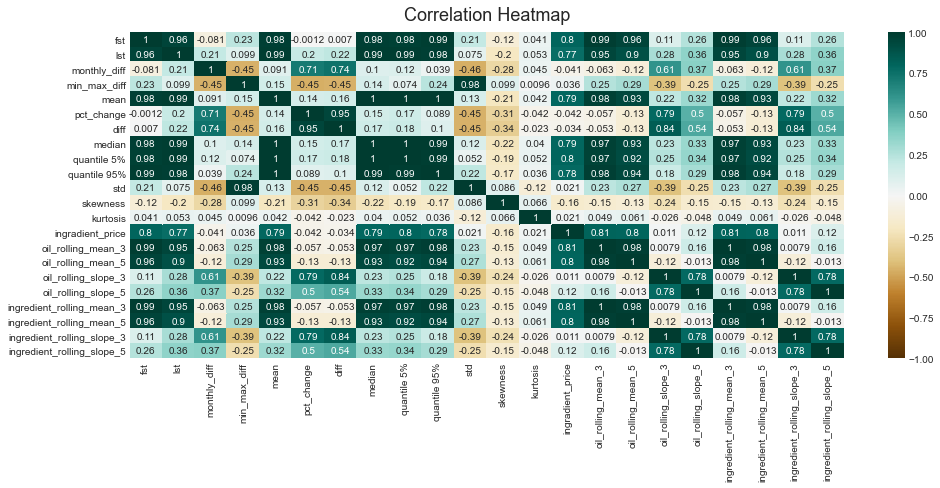

In [25]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_oil_features.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

# Analitical aproach

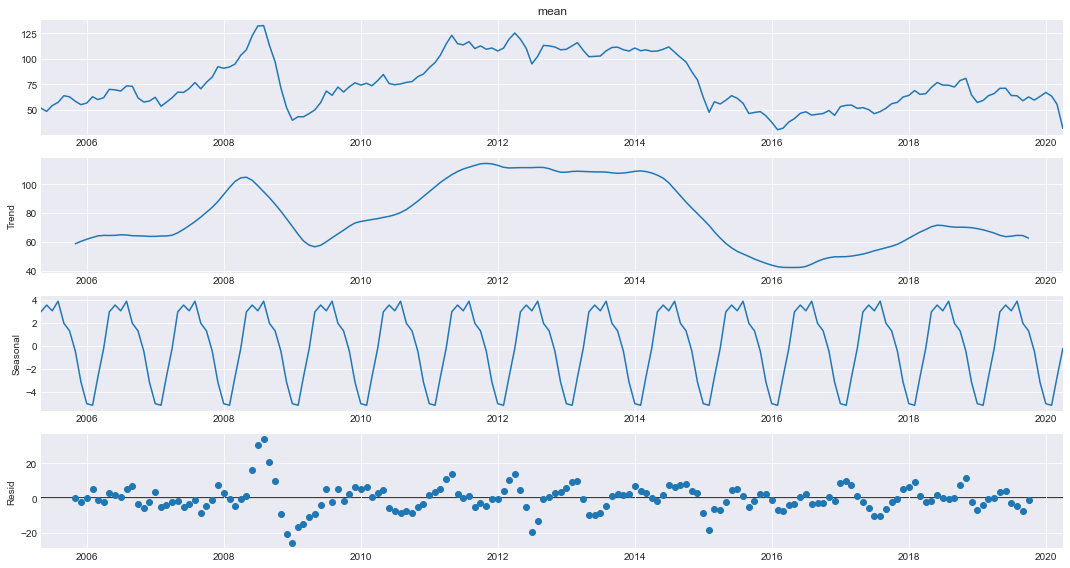

In [205]:
plt.rcParams["figure.figsize"] = (15,8)

decomposition_oil = seasonal_decompose(df_oil_features['mean'], freq=12, model='Multiplicative')  
decomposition_oil.plot();

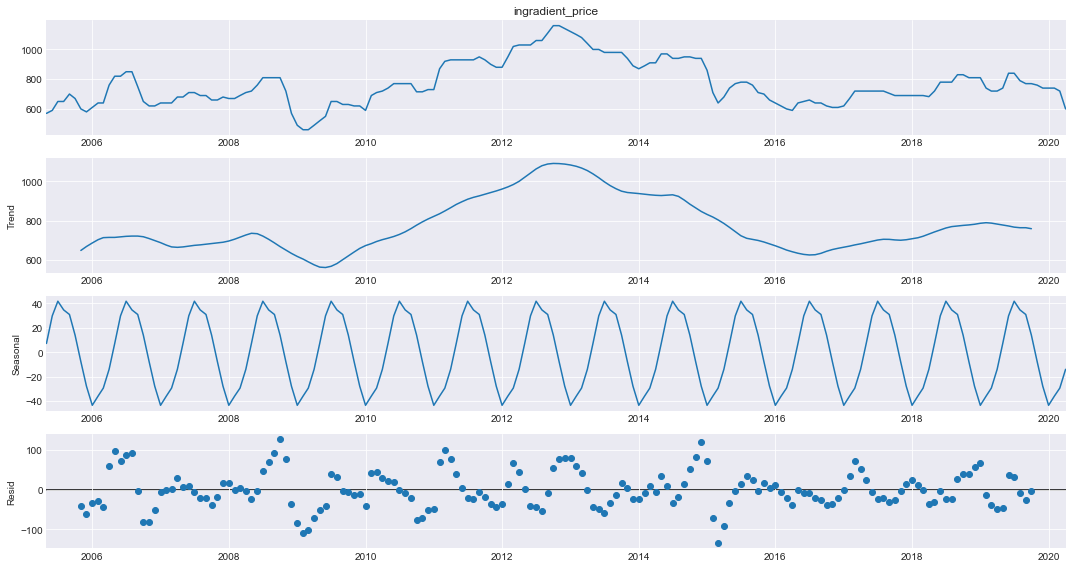

In [210]:
plt.rcParams["figure.figsize"] = (15,8)

decomposition_ingradient = seasonal_decompose(df_oil_features['ingradient_price'], freq=12, model='Multiplicative')  
decomposition_ingradient.plot();

In [207]:
normalize(decomposition_oil.resid).shift(10)

Date
2005-05-01         NaN
2005-06-01         NaN
2005-07-01         NaN
2005-08-01         NaN
2005-09-01         NaN
                ...   
2019-12-01    0.367564
2020-01-01    0.419745
2020-02-01    0.434996
2020-03-01    0.493424
2020-04-01    0.500910
Name: resid, Length: 180, dtype: float64

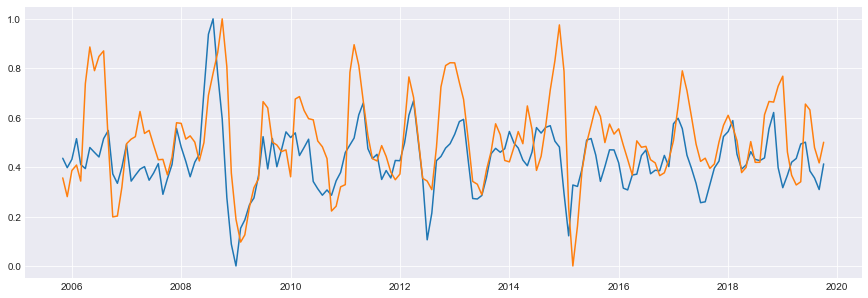

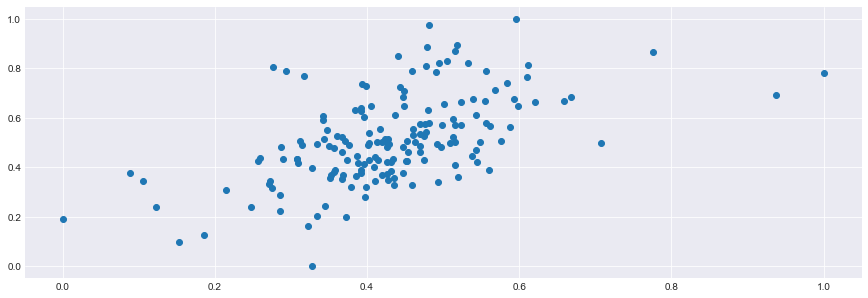

In [255]:
plt.rcParams["figure.figsize"] = (15,5)
lag = 10
plt.plot(normalize(decomposition_oil.resid))
plt.plot(normalize(decomposition_ingradient.resid))
plt.show()
plt.scatter(normalize(decomposition_oil.resid), normalize(decomposition_ingradient.resid))

In [217]:
# decomposition_oil.resid.hist(bins=100)

Date
2005-12-01    0.096341
2006-01-01    0.092703
2006-02-01    0.093790
2006-03-01    0.096871
2006-04-01    0.085437
                ...   
2019-12-01    0.094467
2020-01-01    0.094467
2020-02-01    0.094467
2020-03-01    0.094467
2020-04-01    0.094467
Name: resid, Length: 172, dtype: float64

In [251]:
COND = (normalize(decomposition_oil.resid.diff())<0.3) & ( (normalize(decomposition_ingradient.resid.pct_change())<0.1) )# & (normalize(decomposition_ingradient.resid.pct_change())>0.1) ) 

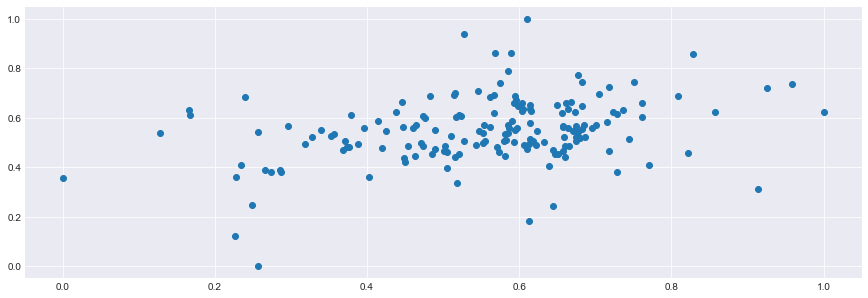

In [254]:
plt.scatter(normalize(decomposition_oil.resid.diff()).loc[ :],
            normalize(decomposition_ingradient.resid.diff()).loc[:])

In [ ]:
decomposition.seasonal

##### The seasonality hasa been observed

In [34]:
plt.rcParams["figure.figsize"] = (11,5)

## Cross-correlatin analysis

In [154]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

WINDOW = 12
d1 = df_oil_features['mean'].div(df_aux.ingradient[0]).mul(100).sub(100)##.rolling(WINDOW).mean().diff().copy()#.diff()
d2 = df_oil_features['ingradient_price'].div(df_aux.ingradient[0]).mul(100).sub(100)##.rolling(WINDOW).mean().diff().copy()#.diff()

rs = [crosscorr(d1,d2, lag) for lag in range(-10,10+1)]

In [155]:
assert(d1.shape==d2.shape)
# lag = 1
# np.corrcoef(d1.shift(lag).dropna(), d2[lag:])

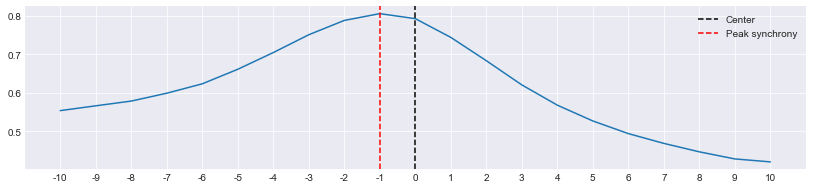

In [156]:
offset = np.floor(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2-1),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
# ax.set(title=f'Offset = {offset} frames\nS1 leads <> S2 leads',ylim=[.1,.31],xlim=[0,20], xlabel='Offset',ylabel='Pearson r')
ax.set_xticks(list(range(20+1)))
ax.set_xticklabels(list(range(-10,10+1)));
plt.legend()

###### The strongest lagged correlation is 1 month. That means that ingradient price is strongly dependent on oil price from last month

In [138]:
from sklearn.preprocessing import power_transform

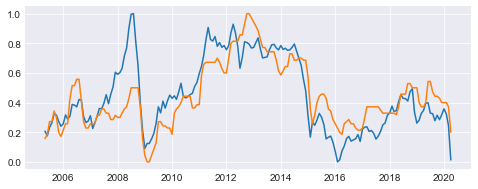

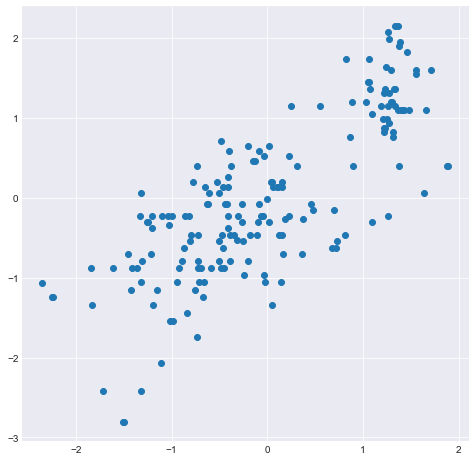

In [158]:
normalize = lambda x: (x-x.min())/(x.max()-x.min())
standarize = lambda x: (x-x.mean())/(x.std())
oil = normalize(df_oil_features['mean'].div(df_aux.ingradient[0]).mul(100).sub(100))#df_oil_features['mean'].rolling(WINDOW).mean().diff())
ingradient = normalize(df_oil_features['ingradient_price'].div(df_aux.ingradient[0]).mul(100).sub(100))#df_oil_features['ingradient_price'].rolling(WINDOW).mean().diff())

df_aux = pd.DataFrame({'oil':df_oil_features['mean'], 'ingradient':df_oil_features['ingradient_price']})

plt.plot(oil)
plt.plot(ingradient)
plt.show()
plt.figure(figsize=(8,8))
plt.scatter(power_transform(oil.iloc[:].values.reshape(-1,1)), power_transform(ingradient.iloc[:].values.reshape(-1,1)))

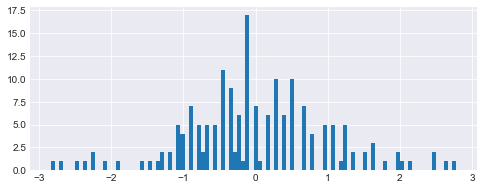

In [147]:
plt.hist(power_transform(ingradient.iloc[:].values.reshape(-1,1)), bins=100);

In [38]:
# df_aux.corr()

Text(0.5, 0.98, 'Nnormalize oil and ingradient prices data and rolling window correlation')

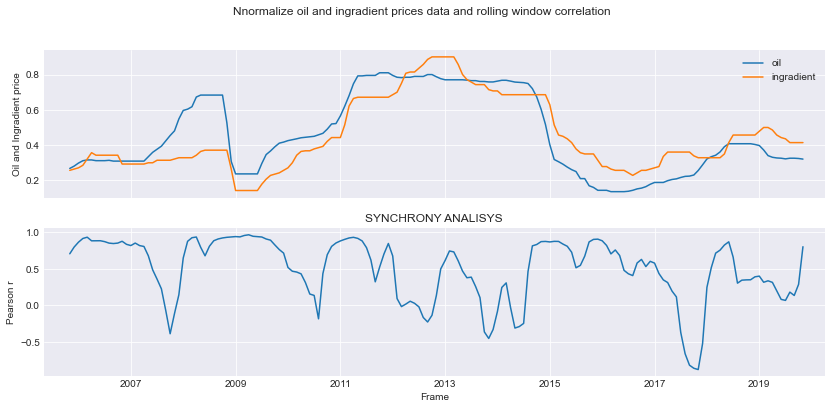

In [39]:
# Set window size to compute moving window synchrony.
window_size = 12
# Compute rolling window synchrony
rolling_r = d1.rolling(window=window_size, center=True).corr(d2)
f,ax=plt.subplots(2,1,figsize=(14,6),sharex=True)
df_aux[['oil', 'ingradient']].apply(normalize).rolling(window=window_size,center=True).median().plot(ax=ax[0])
ax[0].set(xlabel='Frame',ylabel='Oil and Ingradient price')
rolling_r.plot(ax=ax[1])
ax[1].set(xlabel='Frame',ylabel='Pearson r')
plt.title("SYNCHRONY ANALISYS")
plt.suptitle("Nnormalize oil and ingradient prices data and rolling window correlation")

<AxesSubplot:>

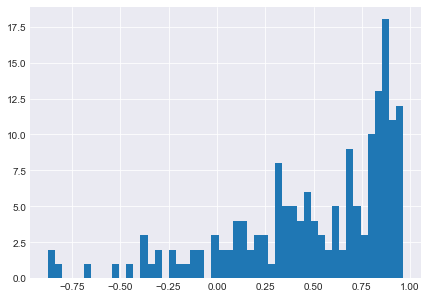

In [40]:
rolling_r.hist(bins=50, figsize=(7,5))

## Short time cross-correlation
##### Windowed time lagged cross correlation

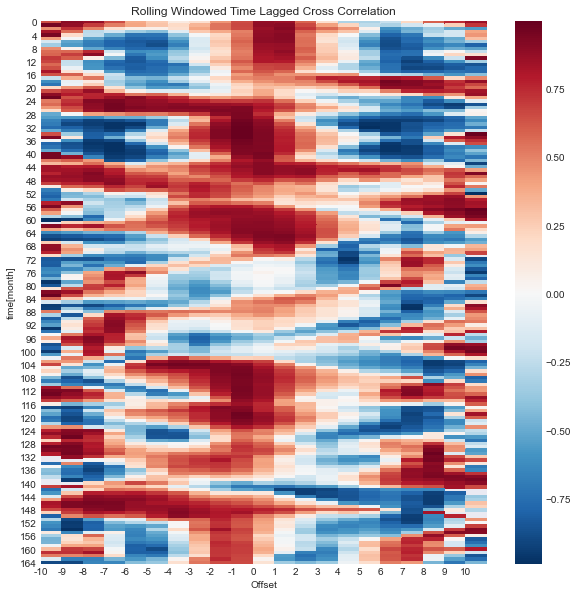

In [41]:
window_size = 15
t_start = 0
t_end = t_start + window_size
step_size = 1
rss=[]
dates = []
while t_end < 180:
    d1 = df_aux['oil'].iloc[t_start:t_end]
    d2 = df_aux['ingradient'].iloc[t_start:t_end]
    rs = [crosscorr(d1,d2, lag, wrap=False) for lag in range(-10,10+1)]
    rss.append(rs)
    dates.append(d1.index[-1])
    t_start = t_start + step_size
    t_end = t_end + step_size
rss = pd.DataFrame(rss)

f,ax = plt.subplots(figsize=(10,10))
sns.heatmap(rss,cmap='RdBu_r',ax=ax)
ax.set(title=f'Rolling Windowed Time Lagged Cross Correlation',xlabel='Offset',ylabel='time[month]')
ax.set_xticks(list(range(20+1)))
ax.set_xticklabels(list(range(-10,10+1)));

C:\Installations\lib\site-packages\seaborn\axisgrid.py:2073: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


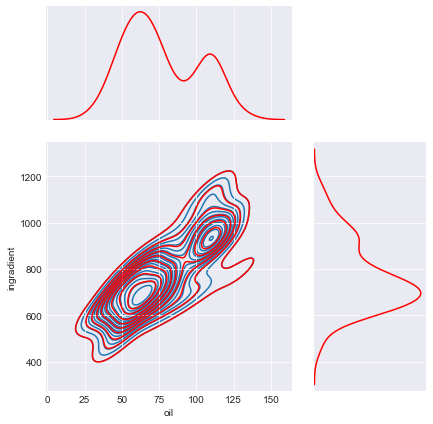

In [42]:
sns.jointplot("oil", "ingradient", data=df_aux,kind="kde",size=6,ratio=2,color="red").plot_joint(sns.kdeplot, zorder=0, n_levels=20)

In [43]:
# We can see two "densities" in distribution -> could be usefeull for futher/optional analysis

<AxesSubplot:>

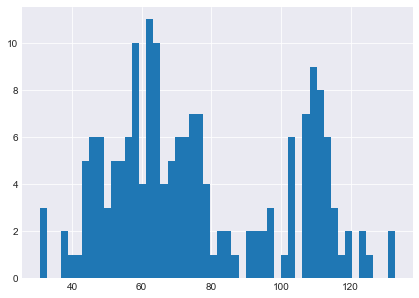

In [44]:
df_aux['oil'].hist(bins=50, figsize=(7,5))

<AxesSubplot:>

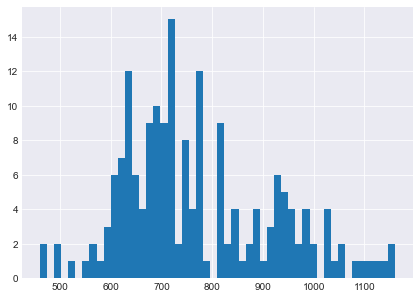

In [45]:
df_aux['ingradient'].hist(bins=50, figsize=(7,5))

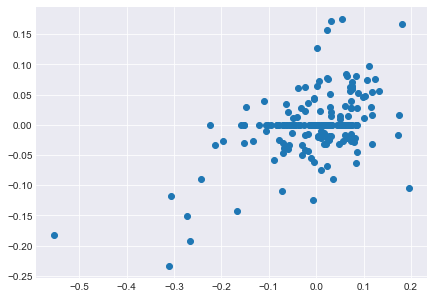

In [46]:
log_ret = lambda x: np.log(x) - np.log(x.shift(1))
# plt.scatter(, )
plt.figure(figsize=(7,5))
plt.scatter(df_aux[['oil']].apply(log_ret), df_aux[['ingradient']].apply(log_ret))

<AxesSubplot:xlabel='Date'>

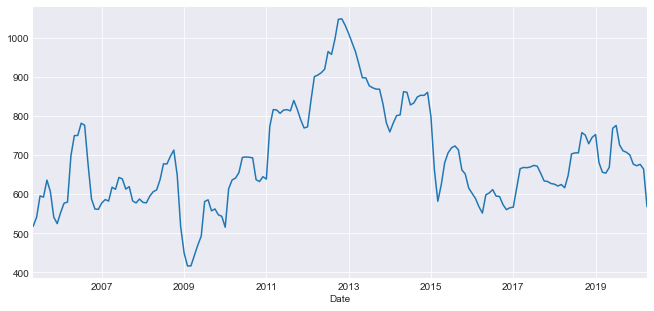

In [47]:
df_aux['price_diff'] = (df_aux['ingradient'] - df_aux['oil'])
df_aux['price_diff'].plot()

In [48]:
df_aux['month_no'] = df_aux.reset_index()['Date'].dt.month.values

In [49]:
df_aux

,oil,ingradient,price_diff,month_no
Date,,,,
2005-05-01,51.883810,570.0,518.116190,5
2005-06-01,48.645455,590.0,541.354545,6
2005-07-01,54.354545,650.0,595.645455,7
2005-08-01,57.520000,650.0,592.480000,8
2005-09-01,63.983478,700.0,636.016522,9
...,...,...,...,...
2019-12-01,63.211905,740.0,676.788095,12
2020-01-01,67.217143,740.0,672.782857,1
2020-02-01,63.645455,740.0,676.354545,2


In [60]:
plt.rcParams["figure.figsize"] = (8,3)

<AxesSubplot:xlabel='month_no'>

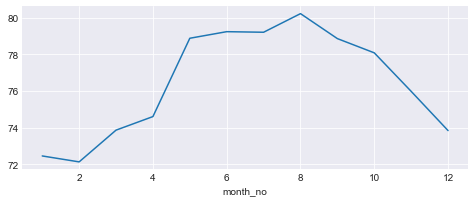

In [61]:
df_aux.groupby('month_no')['oil'].mean().plot()

<AxesSubplot:xlabel='month_no'>

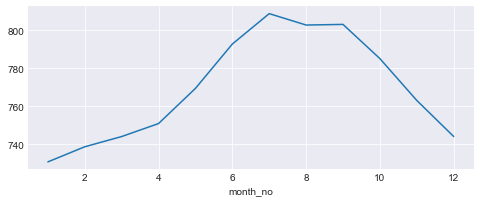

In [62]:
df_aux.groupby('month_no')['ingradient'].mean().plot()

<AxesSubplot:xlabel='month_no'>

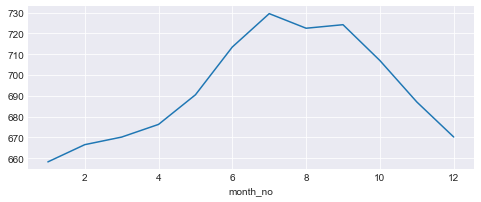

In [63]:
df_aux.groupby('month_no')['price_diff'].mean().plot()

## at the turn of the year, prices are falling

<AxesSubplot:title={'center':'ingradient\nChange price (in %)'}, xlabel='Date'>

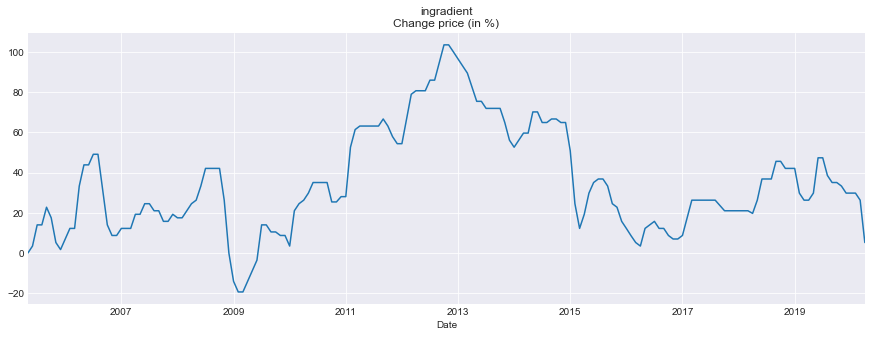

In [64]:
diff_s = df_aux.ingradient.div(df_aux.ingradient[0]).mul(100).sub(100)
diff_s.plot(figsize=(15, 5), title='ingradient\nChange price (in %)')

# Shifting / Creating lag features

## The model is predicting 1 month ahead using oil price and ingredient prices features from 4 previous months

In [65]:
X = df_oil_features.copy()#[df_oil_features.columns.difference(['ingredient_price'])].copy()
y = df_oil_features['ingradient_price'].copy()

X = pd.concat([

    X.shift(4).add_suffix('[t4]'),
    X.shift(3).add_suffix('[t3]'),
    X.shift(2).add_suffix('[t2]'),
    X.shift(1).add_suffix('[t1]'),
        X,

], axis=1).dropna()

X = X[X.columns.difference(['ingradient_price'])].copy()

y = y.loc[X.index]

# lag = 2
# y = y.loc[X.index].shift(-lag)
# X = X.iloc[:-lag]
# y = y.iloc[:-lag]

In [66]:
X.columns

Index(['diff', 'diff[t1]', 'diff[t2]', 'diff[t3]', 'diff[t4]', 'fst',
       'fst[t1]', 'fst[t2]', 'fst[t3]', 'fst[t4]',
       ...
       'skewness', 'skewness[t1]', 'skewness[t2]', 'skewness[t3]',
       'skewness[t4]', 'std', 'std[t1]', 'std[t2]', 'std[t3]', 'std[t4]'],
      dtype='object', length=109)

In [67]:
X.shape, y.shape

((176, 109), (176,))

In [68]:
X_train, y_train = X.iloc[:120].copy(), y.iloc[:120].copy()
X_test, y_test = X.iloc[120:].copy(), y.iloc[120:].copy()

In [69]:
from sklearn.preprocessing import StandardScaler

In [70]:
scaler = StandardScaler()

In [71]:
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

X_train_std = pd.DataFrame(X_train_std, index=X_train.index,columns=X_train.columns)
X_test_std = pd.DataFrame(X_test_std, index=X_test.index,columns=X_test.columns)

## Feature selection

In [72]:
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.ensemble import RandomForestRegressor

feats = X_train_std.columns.values
sel = SelectKBest(f_regression, int(len(feats) * 0.2) )
_ = sel.fit_transform(X_train_std, y_train)
print("Removed features: ", feats[~sel.get_support()])

cols = X_train_std.columns.difference(feats[~sel.get_support()])
X_train_std = X_train_std[cols]
X_test_std = X_test_std[cols]

Removed features:  ['diff' 'diff[t1]' 'diff[t2]' 'diff[t3]' 'diff[t4]' 'fst[t2]' 'fst[t3]'
 'fst[t4]' 'ingradient_price[t4]' 'ingredient_rolling_mean_3[t2]'
 'ingredient_rolling_mean_3[t3]' 'ingredient_rolling_mean_3[t4]'
 'ingredient_rolling_mean_5[t1]' 'ingredient_rolling_mean_5[t2]'
 'ingredient_rolling_mean_5[t3]' 'ingredient_rolling_mean_5[t4]'
 'ingredient_rolling_slope_3' 'ingredient_rolling_slope_3[t1]'
 'ingredient_rolling_slope_3[t2]' 'ingredient_rolling_slope_3[t3]'
 'ingredient_rolling_slope_3[t4]' 'ingredient_rolling_slope_5'
 'ingredient_rolling_slope_5[t1]' 'ingredient_rolling_slope_5[t2]'
 'ingredient_rolling_slope_5[t3]' 'ingredient_rolling_slope_5[t4]'
 'kurtosis' 'kurtosis[t1]' 'kurtosis[t2]' 'kurtosis[t3]' 'kurtosis[t4]'
 'lst' 'lst[t3]' 'lst[t4]' 'mean[t2]' 'mean[t3]' 'mean[t4]' 'median[t2]'
 'median[t3]' 'median[t4]' 'min_max_diff' 'min_max_diff[t1]'
 'min_max_diff[t2]' 'min_max_diff[t3]' 'min_max_diff[t4]' 'monthly_diff'
 'monthly_diff[t1]' 'monthly_diff[t2]' 'mo

#### Columns used to predictions

In [73]:
X_test_std.columns

Index(['fst', 'fst[t1]', 'ingradient_price[t1]', 'ingradient_price[t2]',
       'ingradient_price[t3]', 'ingredient_rolling_mean_3',
       'ingredient_rolling_mean_3[t1]', 'ingredient_rolling_mean_5', 'lst[t1]',
       'lst[t2]', 'mean', 'mean[t1]', 'median', 'median[t1]',
       'oil_rolling_mean_3', 'oil_rolling_mean_3[t1]', 'oil_rolling_mean_5',
       'quantile 5%', 'quantile 5%[t1]', 'quantile 5%[t2]',
       'quantile 95%[t1]'],
      dtype='object')

#### Model selection/training/hyperparameter tuning (optional)

In [74]:
space={
    'alpha': hp.uniform ('alpha', 1,9),
    'seed': 0
    }

In [75]:
def objective(space):
    model = Ridge(alpha=space['alpha'])
    
    evaluation = [( X_train_std, y_train), ( X_test_std, y_test)]
    
    model.fit(X_train_std, y_train)

    pred = model.predict(X_test_std)
    error = mae(y_test, pred)
    print ("SCORE:", error)
    return {'loss': -error, 'status': STATUS_OK }

In [77]:
# trials = Trials()

# best_hyperparams = fmin(fn = objective,
#                         space = space,
#                         algo = tpe.suggest,
#                         max_evals = 20,
#                         trials = trials);

In [78]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

In [79]:
from sklearn.linear_model import SGDRegressor, Ridge
from sklearn.svm import LinearSVR

In [80]:
# model = Ridge(alpha=best_hyperparams['alpha'])
model = LinearRegression()
model.fit(X_train_std, y_train)
# results = model.evals_result()

LinearRegression()

In [81]:
# model = RandomForestRegressor(n_estimators=2)
# model.fit(X_train, y_train)

In [82]:
from sklearn.metrics import mean_squared_error

y_pred_train = model.predict(X_train_std)
y_pred_train = np.round(y_pred_train, decimals=-1)

y_pred_test = model.predict(X_test_std)
y_pred_test = np.round(y_pred_test, decimals=-1)

print(mean_squared_error(y_train, y_pred_train))
print(mean_squared_error(y_test, y_pred_test))

934.6388739586133
525.9826388888889


#### After several (manual) attempts - basic LenearRegression model has been found as best

In [85]:
# 933.8055406252801
# 525.9826388888889

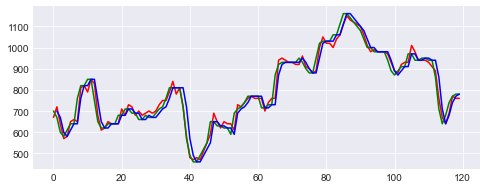

In [86]:
investigate = 200
plt.plot(pd.Series(y_pred_train).iloc[:investigate], c='r')
plt.plot(y_train.values[:investigate], c='g')
plt.plot(y_train.shift(1).values[:investigate], c='b')

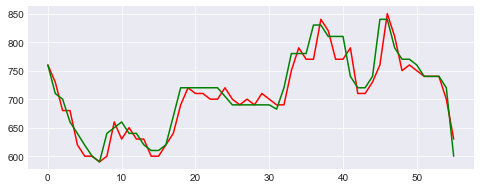

In [87]:
investigate = None
plt.plot(pd.Series(y_pred_test).iloc[:investigate], c='r')
plt.plot(y_test.values[:investigate], c='g')
# plt.plot(y_test.shift(1).values[:investigate], c='b')

# Validation method
#### below the method of validation has been showcase visually

In [88]:
from sklearn.model_selection import TimeSeriesSplit

16 10


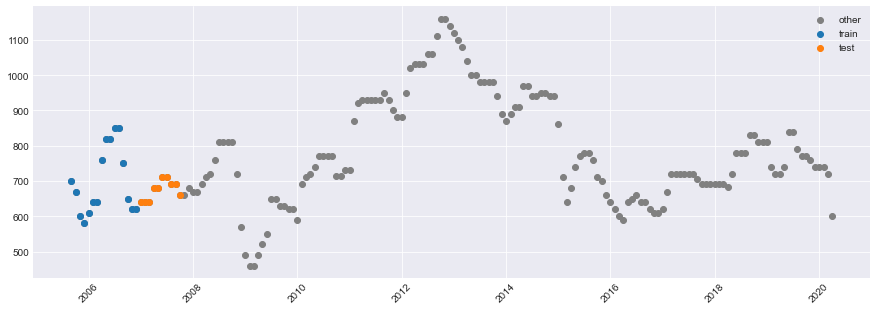

26 10


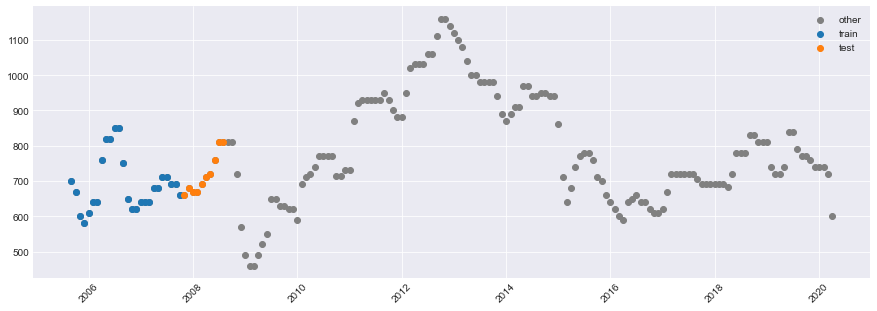

36 10


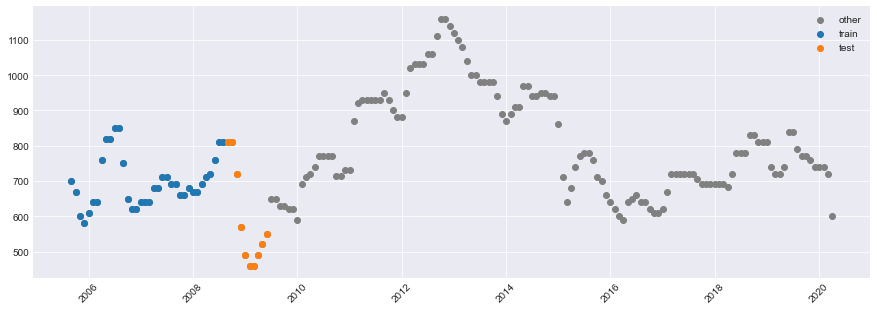

46 10


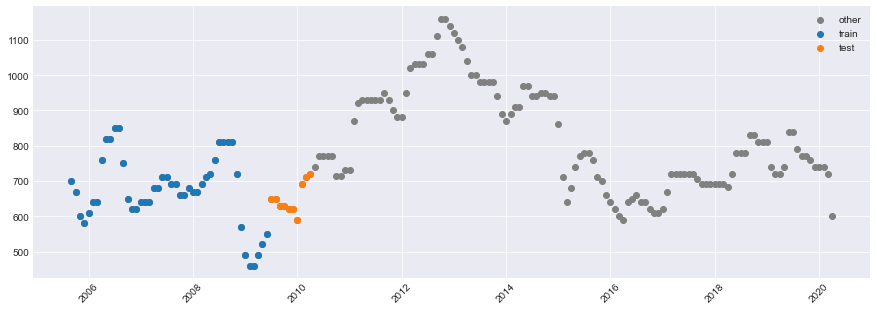

56 10


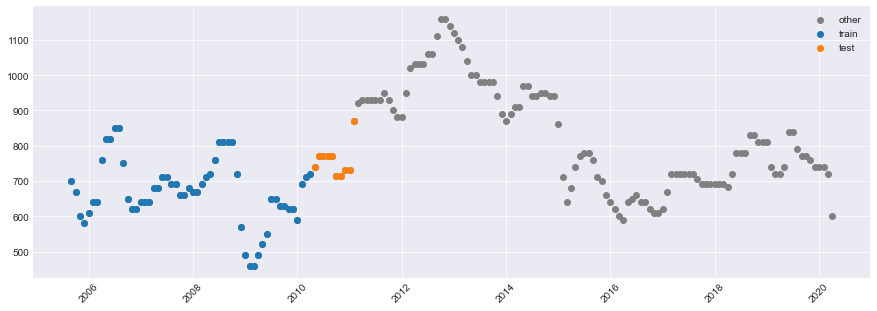

60 10


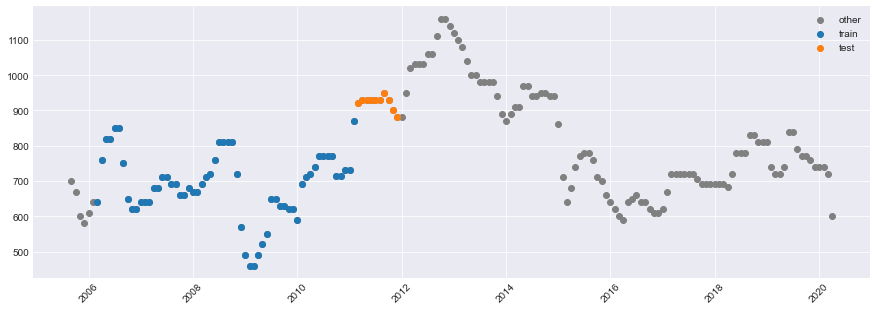

60 10


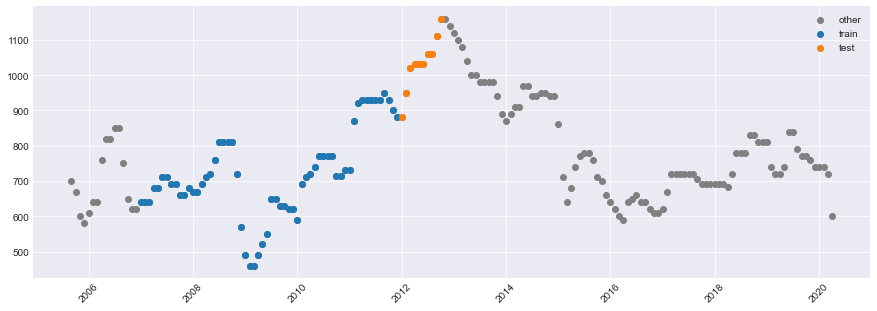

60 10


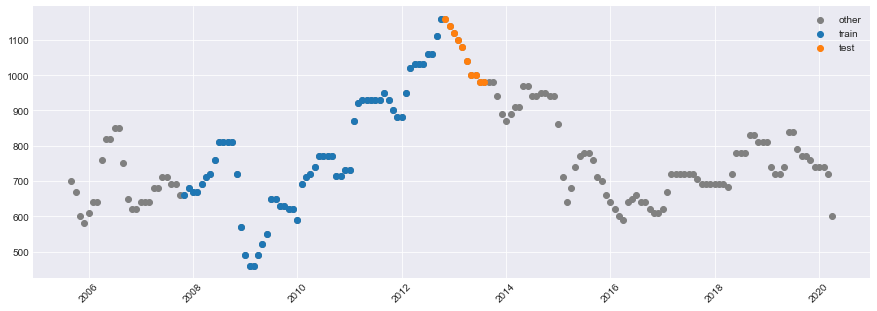

60 10


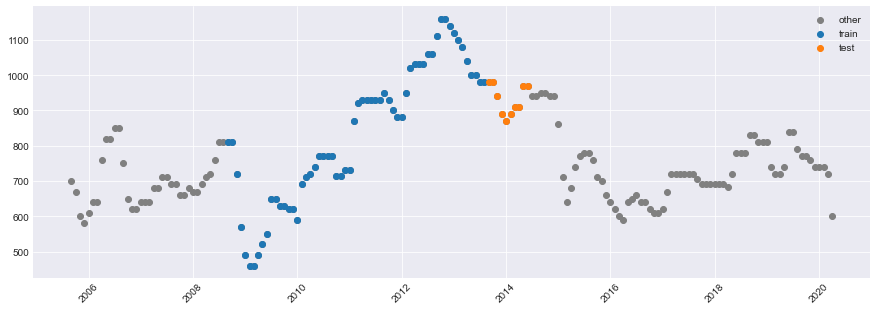

60 10


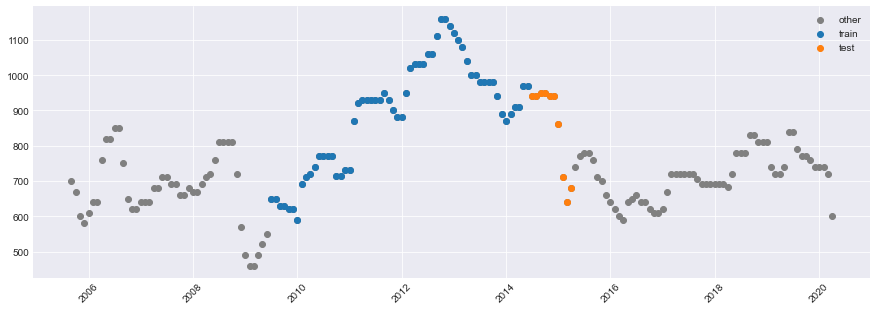

60 10


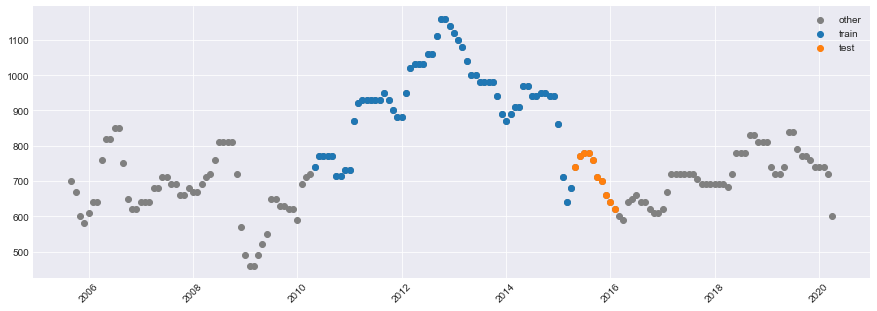

60 10


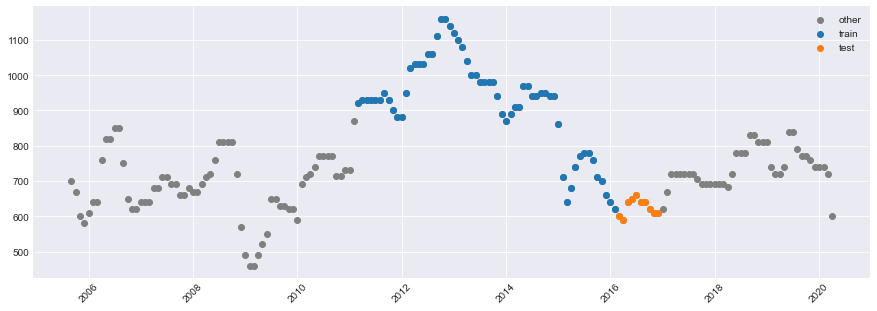

60 10


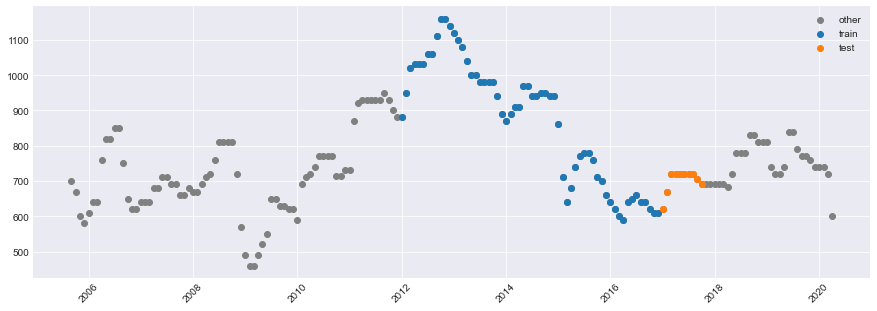

60 10


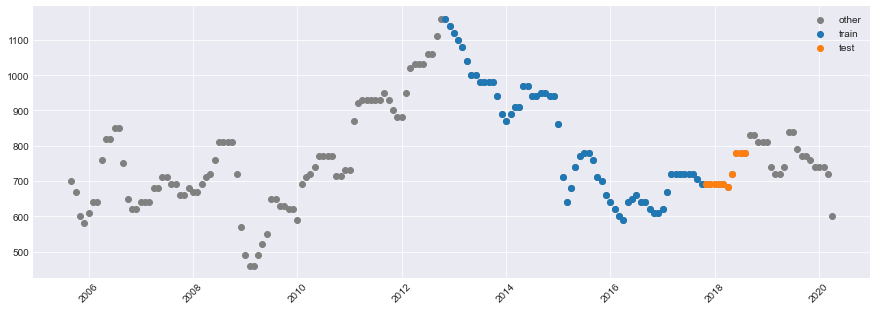

60 10


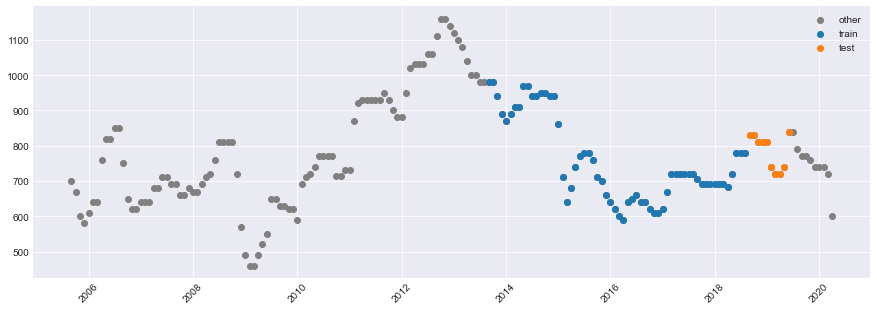

60 10


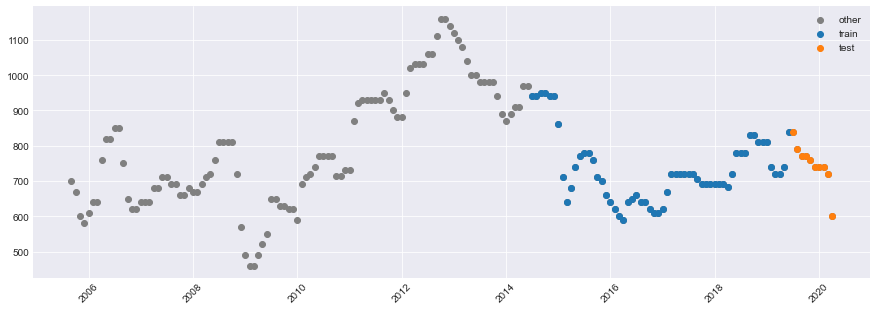

In [89]:
dates = X.index.values

cv = TimeSeriesSplit(n_splits=16, max_train_size=12*5) #max_train_size=900
for train_ids, test_ids in cv.split(X[cols]):
    print(len(train_ids), len(test_ids))
    plt.figure(figsize=(15, 5))
    plt.scatter(dates, y, label='other', color='gray')
    plt.scatter(dates[train_ids],y[train_ids], label='train')
    plt.scatter(dates[test_ids], y[test_ids], label='test')
    
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()


In [100]:
def plot_results(dates_train, dates_test, y_train, y_test, y_pred):
    plt.figure(figsize=(15, 5))
    plt.plot(dates_train, y_train, 'o-', label='train')
    plt.plot(dates_test, y_test, 'o-.', label='test')
    plt.plot(dates_test, y_pred, 'x-.', label='forecast')
    plt.title('Ingradient price\nmae={},mape={}'.format( np.round(mae(y_test, y_pred), 2), np.round(mape(y_test, y_pred),2) ))
    plt.legend()
    plt.show();

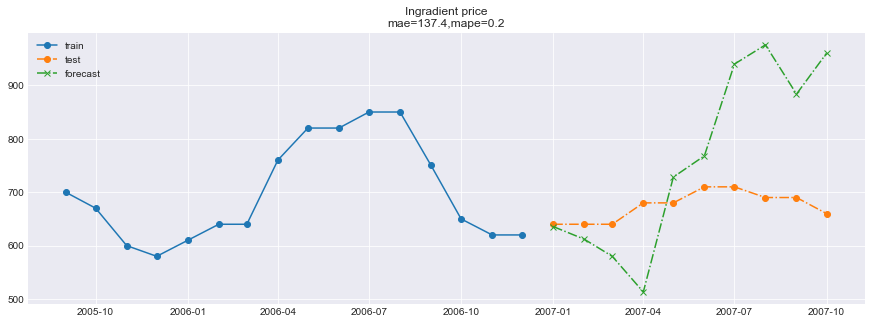

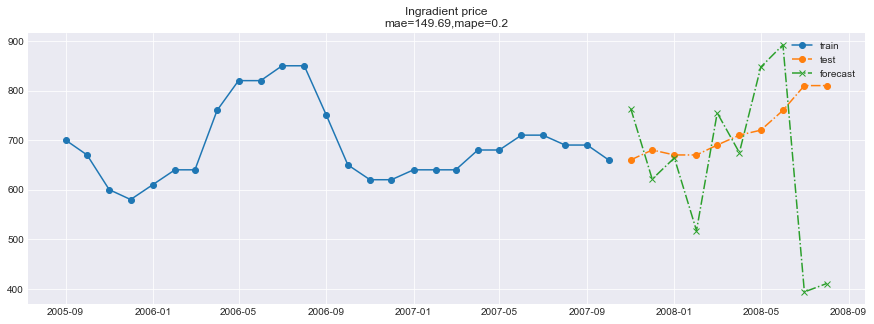

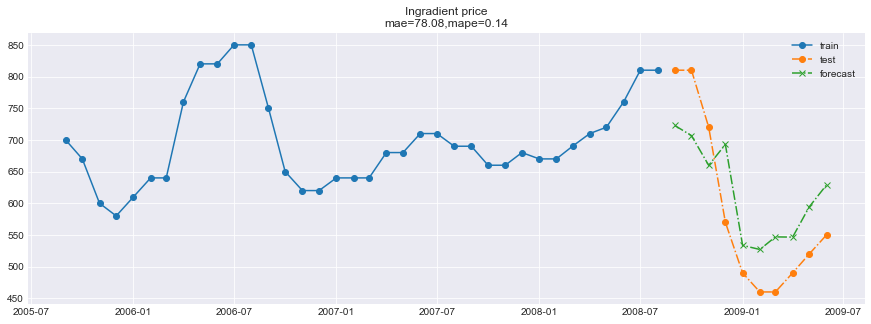

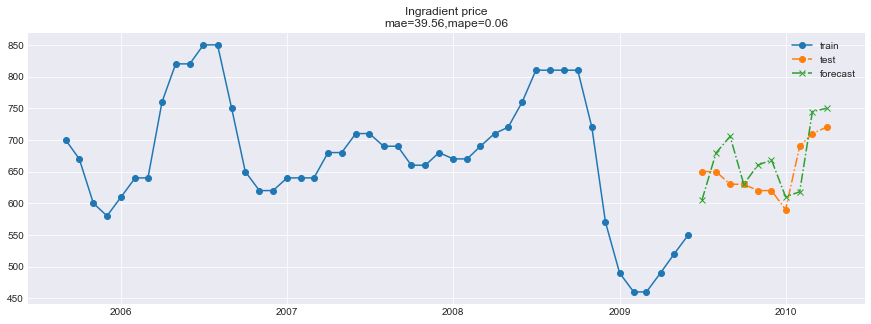

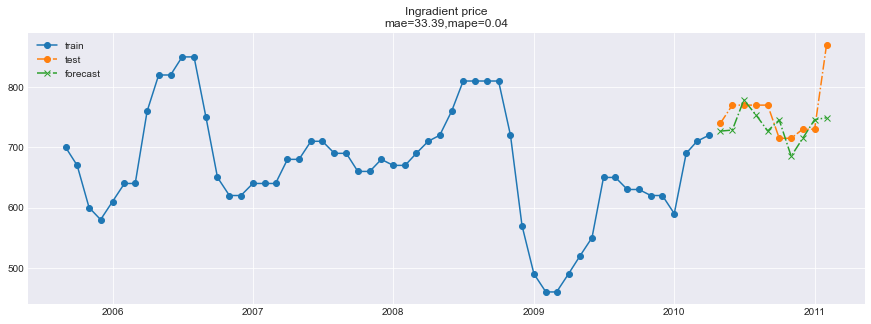

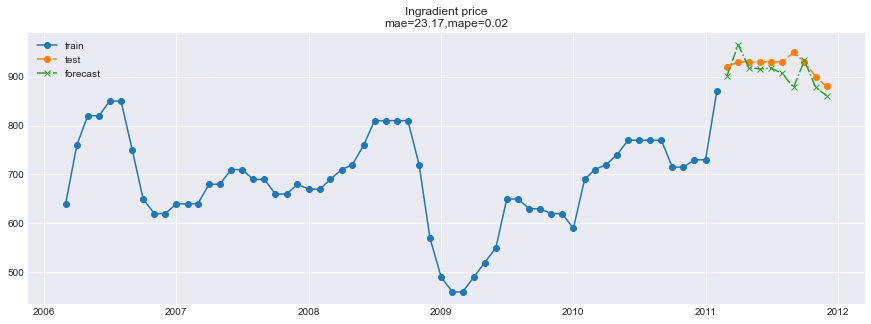

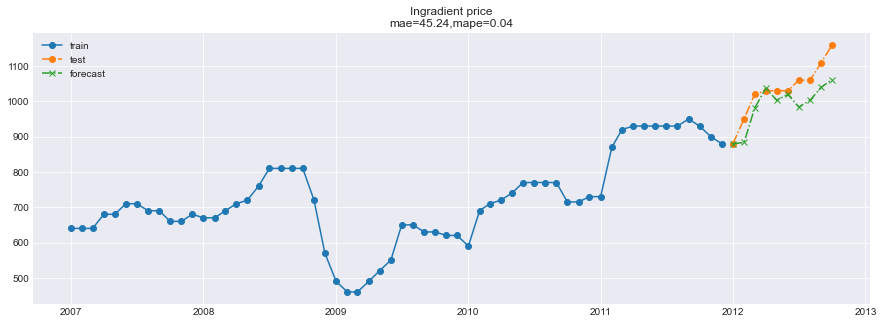

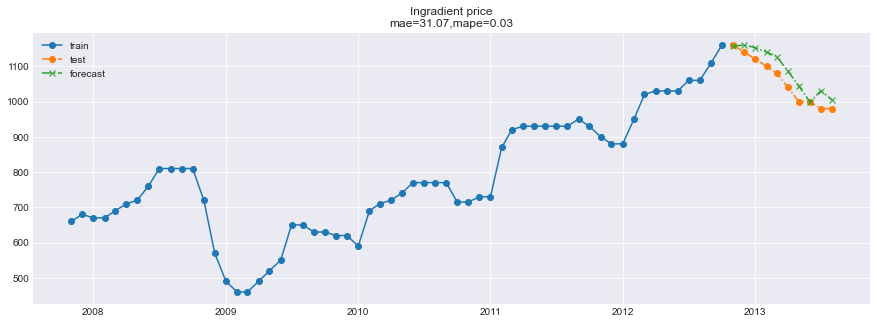

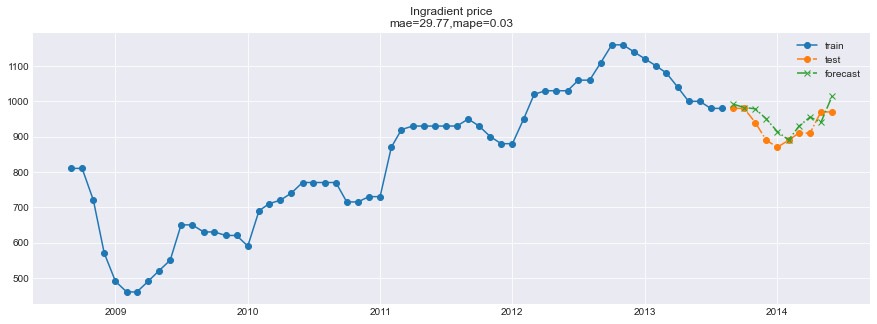

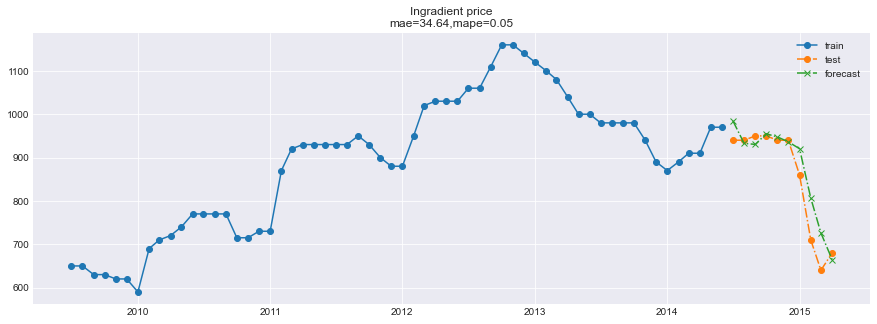

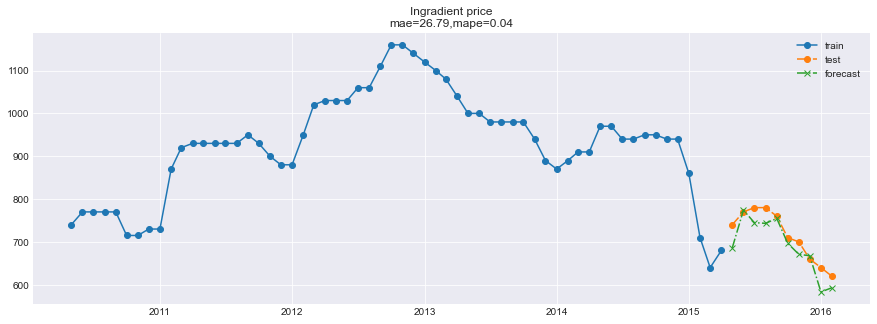

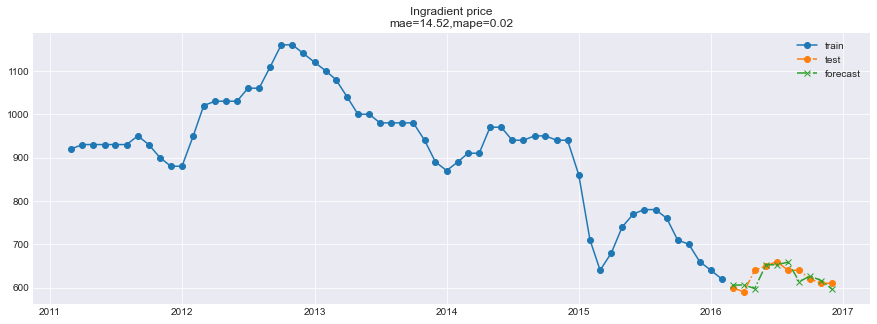

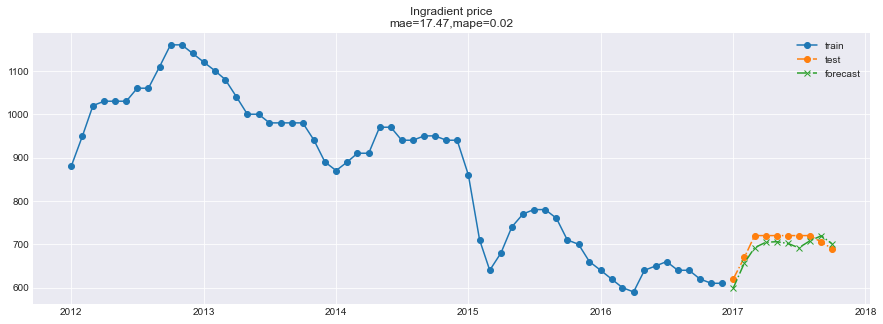

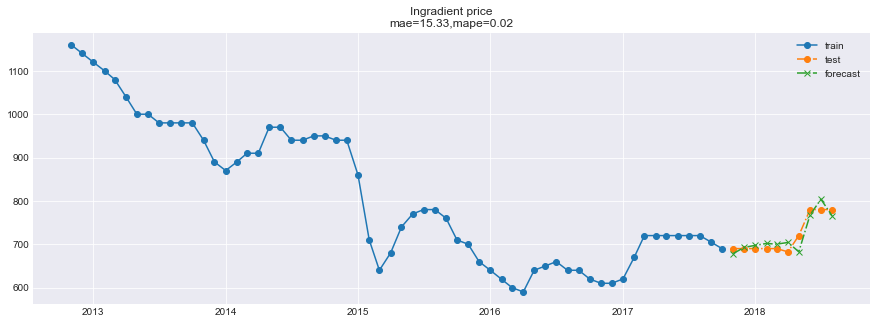

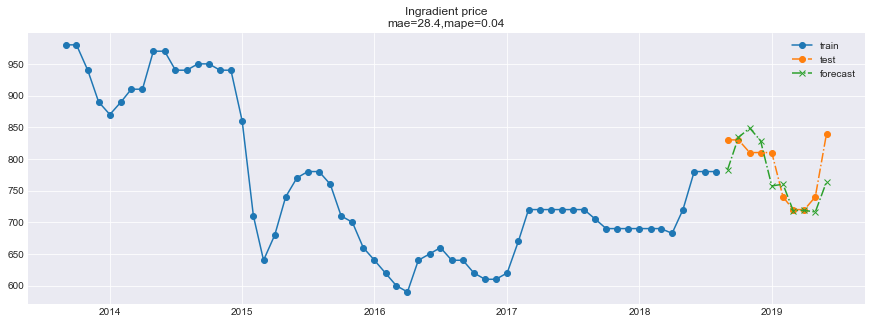

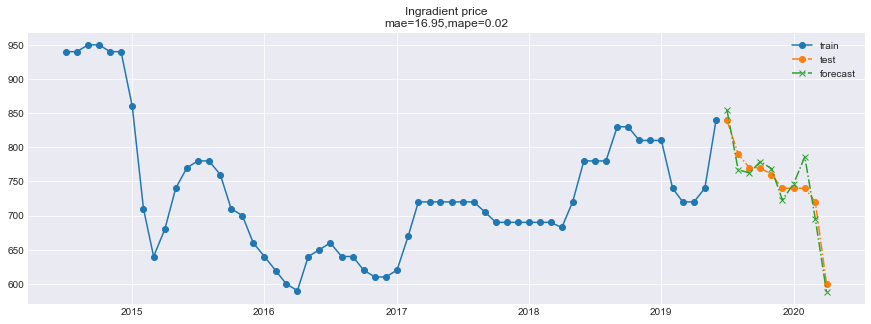

(45.09247173093681,
 40.09996702000412,
 [137.398973756874,
  149.6930454439067,
  78.08347377701479,
  39.55820852372157,
  33.39460336034291,
  23.165240499489663,
  45.24439317762521,
  31.069661089552756,
  29.769985056461678,
  34.64091610049384,
  26.790629191228597,
  14.51900206256995,
  17.470721468423484,
  15.331475318368746,
  28.397369667412136,
  16.95184920150292])

In [101]:
def run_cv_model(X, y, model = LinearRegression(), n_splits=16):
    scores = []

    cv = TimeSeriesSplit(n_splits=n_splits, max_train_size=12*5)
    for train_ids, test_ids in cv.split(X):
        model.fit( X.iloc[train_ids], y.iloc[train_ids] )
        y_pred = model.predict( X.iloc[test_ids] )
        
        plot_results(dates[train_ids], dates[test_ids], y.iloc[train_ids], y.iloc[test_ids], y_pred)

        score = mae(y.iloc[test_ids], y_pred)
        scores.append(score)

    return np.mean(scores), np.std(scores), scores

mean, std, scores = run_cv_model(X[cols], y)
mean,std, scores

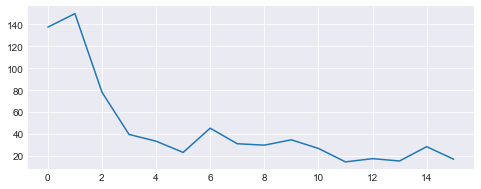

In [99]:
# Mean absolute error during validation
plt.plot(scores)

# What to improve

###### 1) Walk Forward Validation (predict [t+1, t+2, t+3, ..., t+n] based on previous prediction) !!!!

###### 2) Create class for pipeline: Data cleasing -> Feature extraction -> Prediction

In [98]:
### PLAYGROUND

In [83]:
#################################

# model = RandomForestRegressor(n_estimators=10)
# feats = X_train.columns.values

# sel = RFE(model, n_features_to_select=50, verbose=True)
# sel.fit_transform(X_train, y_train)
# print("Removed features: ", feats[~sel.get_support()])

# cols = X_train.columns.difference(feats[~sel.get_support()])
# X_train = X_train[cols]
# X_test = X_test[cols]




# model = RandomForestRegressor(n_estimators=10)
# feats = df_train_l1.columns.values

# sel = RFE(model, step=0.8, n_features_to_select=400, verbose=True)
# sel.fit_transform(df_train_l1[feats], df_train_l1['demand_log'])
# print("Removed features: ", feats[~sel.get_support()])


# space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
#         'gamma': hp.uniform ('gamma', 1,9),
#         'reg_alpha' : hp.quniform('reg_alpha', 0,50,1),
#         'reg_lambda' : hp.uniform('reg_lambda', 0,1),
#         'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
#         'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
#         'n_estimators': hp.quniform("n_estimators", 10, 100, 10),
#         'seed': 0
#     }


# def objective(space):
#     model = XGBRegressor(
#                     n_estimators = 20, max_depth = int(space['max_depth']), gamma = space['gamma'],
#                     reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
#                     colsample_bytree=int(space['colsample_bytree']))
    
#     evaluation = [( X_train, y_train), ( X_test, y_test)]
    
#     model.fit(X_train, y_train,
#             eval_set=evaluation, eval_metric="mae",
#             early_stopping_rounds=10,verbose=False)
    

#     pred = model.predict(X_test)
#     error = mae(y_test, pred)
#     print ("SCORE:", error)
#     return {'loss': -error, 'status': STATUS_OK }

# trials = Trials()

# best_hyperparams = fmin(fn = objective,
#                         space = space,
#                         algo = tpe.suggest,
#                         max_evals = 100,
#                         trials = trials);

# best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])

# model = XGBRegressor(**best_hyperparams)
# evalset = [(X_train, y_train), (X_test, y_test)]
# model.fit(X_train, y_train, eval_set=evalset, early_stopping_rounds=10, verbose=False)
# results = model.evals_result()

# # plot learning curves
# plt.plot(results['validation_0']['rmse'], label='train')
# plt.plot(results['validation_1']['rmse'], label='test')
# # show the legend
# plt.legend()
# # show the plot
# plt.show()